# Fastai TabularModel expermintal setup

This notebook is used for hyperparametertuning

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import holidays
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from fastai.tabular import *
from joblib import load, dump
from torch import nn, optim
from sklearn.metrics import mean_absolute_error

In [3]:
data = '../data/'
showings = load(data+'showings_extra_feature.joblib')
showings.replace(np.inf, 0, inplace=True)
showings.sort_values(by='showtime', inplace=True)
showings.reset_index(drop=True, inplace=True)

### Create the train/validation split

In [4]:
train_valid = showings.loc[(showings.year > 1999) & (showings.year < 2019)]
train_valid.reset_index(drop=True, inplace=True)
split = list(train_valid.loc[train_valid.year > 2016].index)

### Declare what the different columns are

dep_var    = Target Feature  
cat_names  = Categorical Features  
cont_names = Continuous Features  

In [5]:
dep_var = 'coverage'
cat_names = ['room',
             'tmdb_original_language',
             'year',
             'month',
             'week',
             'day',
             'hour',
             'minute',
             'dayofweek',
             'dayofyear',
             'is_month_end',
             'is_month_start',
             'is_quarter_end',
             'is_quarter_start',
             'is_year_end',
             'is_year_start',
             'is_holiday',
             'days_since_release',
             'Action',
             'Adventure',
             'Animation',
             'Comedy',
             'Crime',
             'Documentary',
             'Drama',
             'Family',
             'Fantasy',
             'History',
             'Horror',
             'Music',
             'Mystery',
             'Romance',
             'Science Fiction',
             'TV Movie',
             'Thriller',
             'War',
             'Western']
cont_names = ['seats',
              'tmdb_popularity',
              'tmdb_vote_average',
              'tmdb_vote_count',
              'tmdb_runtime',
              'tmdb_budget',
              'weekday_cos',
              'weekday_sin',
              'day_month_cos',
              'day_month_sin',
              'month_year_cos',
              'month_year_sin',
              'day_year_cos',
              'day_year_sin',
              'hour_cos',
              'hour_sin',
              'clock_cos',
              'clock_sin',
              'min_cos',
              'min_sin']
procs = [FillMissing, Categorify, Normalize]

### Put the data into Databunches that the TabularModel will use

In [6]:
data = (TabularList.from_df(train_valid, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(split)
                   .label_from_df(cols=dep_var)
                   .databunch())

test_set = showings.loc[(showings.year > 2018) & (showings.year < 2020)]
test_set.reset_index(drop=True, inplace=True)
test = (TabularList.from_df(test_set,
                            cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_none()
                   .label_from_df(cols=dep_var))
test.valid = test.train
test = test.databunch()

In [7]:
learn = tabular_learner(
                        data, layers=[1000, 500, 250, 125], emb_szs={'room': 333},
                        metrics=mae, y_range=[-.01,1.01],
                        emb_drop=0.15,
                        ps=(0.00, 0.20, 0.15, 0.95)
                       )

In [8]:
learn.opt_func = partial(
    optim.Adam,
    betas   = (0.99, 0.99), # default: (0.9, 0.99)
    eps     = 1e-3,         # default: 1e-8
    amsgrad = False         # default: False
)

In [ ]:
learn.fit_one_cycle(
    8, 
    max_lr = 1e-3,
    wd     = 0.15,
    moms   = (0.95, 0.85)
)

### Save the model

In [ ]:
learn.save('test_tabular_use_this')

In [ ]:
train_dl = data.train_dl
valid_dl = data.valid_dl
test_dl = test.valid_dl

### Get predictions for train, validation and test sets

In [ ]:
preds_train = learn.get_preds(ds_type=DatasetType.Train)
preds_valid = learn.get_preds(ds_type=DatasetType.Valid)
# Changing the dataloader so that we can get predictions for the test set
learn.data.valid_dl = test_dl
preds_test = learn.get_preds(ds_type=DatasetType.Valid)

### Calculates and prints the Mean Absolute Error

In [ ]:
(
    round(mean_absolute_error(preds_train[1], preds_train[0].T[0]), 4),
    round(mean_absolute_error(preds_valid[1], preds_valid[0].T[0]), 4),
    round(mean_absolute_error(preds_test[1],  preds_test[0].T[0]), 4)
)

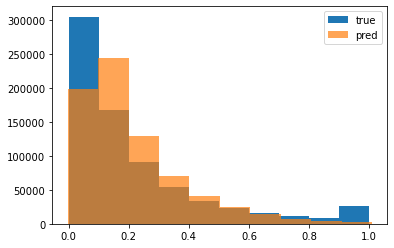

In [16]:
plt.hist(preds_train[1])
plt.hist(preds_train[0].T[0], alpha=.7)
plt.legend(('true', 'pred'))

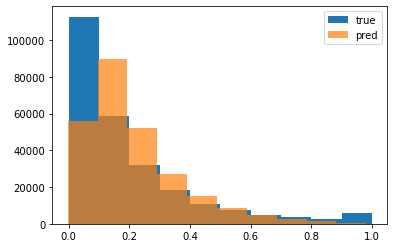

In [17]:
plt.hist(preds_valid[1])
plt.hist(preds_valid[0].T[0], alpha=.7)
plt.legend(('true', 'pred'))

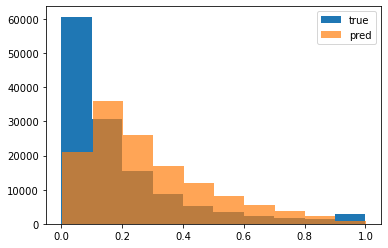

In [18]:
plt.hist(preds_test[1])
plt.hist(preds_test[0].T[0], alpha=.7)
plt.legend(('true', 'pred'))

In [21]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(333, 41)
    (1): Embedding(153, 27)
    (2): Embedding(17, 8)
    (3): Embedding(13, 7)
    (4): Embedding(54, 15)
    (5): Embedding(32, 11)
    (6): Embedding(8, 5)
    (7): Embedding(367, 44)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(25, 10)
    (15): Embedding(48, 14)
    (16): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=210, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_runn